## Data loading

First we need to load the MNIST dataset from disk. We will do 10-class classification for digit 0, 1, .., 9 from the MNIST dataset here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import edf
import mnist_loader
import copy

train_images, train_labels = mnist_loader.load_mnist(section = 'training', path = 'MNIST')
test_images, test_labels = mnist_loader.load_mnist(section = 'testing', path = 'MNIST')

# quickly check the shape of data
print('Train data shape: ', train_images.shape)
print('Train labels shape: ', train_labels.shape)
print('Test data shape: ', test_images.shape)
print('Test labels shape: ', test_labels.shape)


Train data shape:  (60000, 28, 28)
Train labels shape:  (60000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


## A multi-layer perceptron (MLP) network with dropout

**3.3.(a).** We produce the multi-layer perceptron (MLP) class. In this assignment, we implement dropout by adding `dropout` layers between hidden layers. The framework of network is defined below so your task is to implement functional part of `dropout` computational nodes. To help your understanding, I recommend you to draw the computational graph of a 2-layer MLP network including loss nodes.

In [2]:
# Params
class MLPParams:

    nInputs = None
    nHiddens = None
    nOutputs = None
    nLayers = None
    ActivationClass = None
    enableReg = None
    RegClass = None
    alpha = None
    dropOutProb = None
    
# MLP
class MLP:

    def __init__(self, params: MLPParams ):
        self.params = params

    def construct(self):

        params = self.params

        nInputs = int(params.nInputs)
        nHiddens = int(params.nHiddens)
        nOutputs = int(params.nOutputs)
        nLayers = int(params.nLayers)
        ActivationClass = params.ActivationClass
        RegClass = params.RegClass
        enableReg = params.enableReg
        alpha = params.alpha
        dropOutProb = params.dropOutProb

        if RegClass is None:
            enableReg = False
        
        # clean global parameters
        edf.clear_compgraph()

        # input
        x_node = edf.Input()
        y_node = edf.Input()
        loss_nodes = []
        weight_params = []
        
        # 1st layer
        param_first = edf.AffineParams(nInputs, nHiddens)
        weight_params.append( param_first )
        h = DropOut ( ActivationClass (edf.Affine( param_first, x_node )), dropOutProb)

        # reg
        if enableReg:
            reg_loss_node = self.RegClass(param_first.A, alpha)
            loss_nodes.append(reg_loss_node)
            reg_loss_node = self.RegClass(param_first.b, alpha)
            loss_nodes.append(reg_loss_node)

        for i in range(nLayers - 1):

            # hidden layer
            param = edf.AffineParams(nHiddens, nHiddens)
            weight_params.append(param)
            h = DropOut ( ActivationClass ( edf.Affine(param, h) ), dropOutProb)

            if enableReg:
                reg_loss_node = self.RegClass(param.A, alpha)
                loss_nodes.append(reg_loss_node)
                reg_loss_node = self.RegClass(param.b, alpha)
                loss_nodes.append(reg_loss_node)

        # the last layer
        param_last = edf.AffineParams(nHiddens, nOutputs)
        weight_params.append( param_last )
        #prob_node = DropOut ( edf.Softmax (ActivationClass ( edf.Affine(param, h) )), dropOutProb)
        prob_node = edf.Softmax(edf.Affine(param_last, h))

        if enableReg:
            reg_loss_node = self.RegClass(param_last.A, alpha)
            loss_nodes.append(reg_loss_node)
            reg_loss_node = self.RegClass(param_last.b, alpha)
            loss_nodes.append(reg_loss_node)
        
        # loss
        crossloss_node = edf.CrossEntropyLoss(prob_node, y_node)
        sum_node = AverageMiniBatch(crossloss_node)
        loss_nodes.append(sum_node)

        # probability
        self.x_node = x_node
        self.y_node = y_node
        self.loss_node = Add(loss_nodes)
        self.prob_node = prob_node
        self.weight_params = weight_params

    def forward(self, X,y = None):
        
        if y is None:
            y = np.ones_like ( X[:,0],dtype =np.int32)

        # parse input
        self.x_node.value = X
        self.y_node.value = y

        # run
        edf.Forward()

        # get output
        output = np.round(self.output_node.value)

        return output

    def load (self):
        print("TBA")

    def record (self):
        self.rep = copy.deepcopy(self)


Here, we provide a `ReLU` activation node and computational nodes for our MLP network. 

In [3]:
# Add
class Add(edf.CompNode):

    def __init__(self, x_list):
        edf.CompNodes.append(self)
        self.x_list = x_list

    def forward(self):

        value = np.zeros_like(self.x_list[0].value, self.x_list[0].value.dtype)

        for x in self.x_list:
            value += x.value

        self.value = value

    def backward(self):

        for x in self.x_list:
            x.addgrad(np.ones_like(x.value, x.value.dtype)*self.grad[0])

# Average loss over a minibach
class AverageMiniBatch(edf.CompNode):

    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        value = np.average(self.x.value)
        self.value = np.resize(value, (1, 1))

    def backward(self):
        self.x.addgrad(np.ones_like(self.x.value, self.x.value.dtype)/self.x.value.size*self.grad[0])

# ReLU
class ReLU(edf.CompNode):
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        self.value = np.maximum(0, self.x.value)
        # pass

    def backward(self):
        # pass
        v = np.ones_like(self.x.value)
        v[self.x.value <= 0.0] = 0.0
        self.x.addgrad(self.grad * v)

## Dropout

**3.3.(b).** Implement backward and forward parts of a `Dropout` node. In the forward function, we first generate the random mask according to the dropout probability. Then, we filter out the input signal, using the mask. In the backward function, we do backpropagation only on the valid part. Note that dropout should be performed during training. To this end, we use `edf.enable_dropout` to specify whether dropout should be performed or not. If `edf.enable_dropout` is false, this node give input as output without any operation.

In [4]:
# Dropout
class DropOut ( edf.CompNode ):

    def __init__(self, x, dropout_prob = 0.5):
        edf.CompNodes.append(self)
        self.x = x
        self.dropout_prob = dropout_prob

    def forward(self):

        mask = np.ones_like(self.x)
        value = self.x.value
        if edf.enable_dropout:

            #########################################################################
            # TO-DO: implement the forward part of a dropout computation node.
            # when dropout is activated,
            # you first generate the random mask which has the same size with input x.
            # then you filter out signal x according to the generated mask.
            #########################################################################

        self.mask = np.array( mask , dtype = edf.DT)
        self.value = value
        
        
        
        
    def backward(self):

        #########################################################################
        # TO-DO: implement the backward part of a dropout computation node.
        # You compute the gradient while considering the mask we used for forward.
        # then you filter out signal x according to the generated mask.
        #########################################################################
        

IndentationError: expected an indented block (<ipython-input-4-4b35bd885772>, line 22)

We provide functions for training. By passing `optimizer` and `transformer` objects into `train_and_test` function, we can train the network with various optimization methods and data augmentation. About `transformer`, we will talk later. Here we provide the basic optimizer, which update the parameters based on pure gradients and the learning rate. Note that the learning rate is multiplied with the gradient and the multiplication is added to the parameter in `p.UpdateParameters()`. Please see the `edf.py` for details.

In [4]:
# basic gradient descent method
class GDOptimizer:

    def __init__(self):
        print("")

    def initialize (self):
        print("")
           
    def updateParameters (self):

        for p in edf.Parameters:
            p.UpdateParameters()


In [5]:
def run_epoch(batch_size, data, labels, x_node, y_node, prob_node, loss_node = None, optimizer=GDOptimizer(), transformer = None):

    num_samples = len(data)
    total_err = 0.0
    num_batches = num_samples//batch_size


    for i in range(num_batches):
        start, end = i*batch_size, (i+1)*batch_size

        # load supervised training data
        if transformer is None:
            x_node.value = data[start:end].reshape(end - start, -1)
        else:
            x_node.value = transformer.transform ( data[start:end] ).reshape(end - start, -1)
  
        y_node.value = labels[start:end]

        #  forward
        edf.Forward()

        # compute error
        total_err += np.sum(np.not_equal(np.argmax(prob_node.value, axis=1), y_node.value))


        # step
        if loss_node:

            # backpropagation
            edf.Backward(loss_node)
            optimizer.updateParameters()

        if i>0 and i%400 == 0:
            print ("\t Batch {}/{}".format(i, num_batches))

    return 100*total_err/num_samples

def train_and_test(num_epochs, batch_size, x_node, y_node, prob_node, loss_node, optimizer=GDOptimizer(), transformer=None, enable_dropout = False):

    train_err_log = []
    test_err_log = []
    
    # initialize optimizer
    optimizer.initialize()
    
    for epoch in range(num_epochs):

        print("Epoch: {}/{} (learning rate: {})".format(epoch+1, num_epochs, edf.learning_rate))

        edf.enable_dropout = enable_dropout
        train_err = run_epoch(batch_size, train_images, train_labels, x_node, y_node, prob_node, loss_node, optimizer, transformer)
        train_err_log.append(train_err)
        print ("\t Training Error {:.2f} %".format(train_err))

        edf.enable_dropout = False
        test_err = run_epoch(len(test_images), test_images, test_labels, x_node, y_node, prob_node, None, optimizer, None)
        test_err_log.append(test_err)
        print ("\t Test Error {:.2f} %".format(test_err))
        
        # print out the error late per label.
        for i in range(10):
            err_n_per_i = np.sum(np.not_equal(np.argmax(prob_node.value[y_node.value==i], axis=1), y_node.value[y_node.value==i]))
            n_per_i = np.sum(y_node.value==i)
            print( i," : ", err_n_per_i,'/', n_per_i,'  ', '%.2f' % (err_n_per_i / n_per_i))
        

    return train_err_log, test_err_log

def plot(train_err_log, test_err_log):

    plt.xlabel("epochs")
    plt.ylabel("error (%)")
    plt.plot(np.arange(len(test_err_log)), test_err_log, color='red')
    plt.plot(np.arange(len(train_err_log)), train_err_log, color='blue')
    plt.legend(['test error', 'train error'], loc='upper right')
    plt.show()
    plt.clf()

**3.3.(b).i.** Construct a MLP network and train the network without data augmentation. You can activate norm regularization by adding regularization class in this jupyter notebook and changing parameter settings. After constructing the MLP network, train the network and show the error graph.

In [7]:
param = MLPParams()
param.nInputs = 784 # 784-dimension
param.nOutputs = 10 # Output dimension
param.nLayers = 3
param.nHiddens = 64 # Number of neurons in the hidden layer
param.ActivationClass = ReLU
param.RegClass = None
param.alpha = 0.001
param.dropOutProb = 0.5
mlp_ReLU = MLP(param)

**3.3.(b).i.** Train the network with dropout.


Epoch: 1/20 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 61.55 %
	 Test Error 20.75 %
0  :  18 / 980    0.02
1  :  65 / 1135    0.06
2  :  266 / 1032    0.26
3  :  187 / 1010    0.19
4  :  259 / 982    0.26
5  :  343 / 892    0.38
6  :  66 / 958    0.07
7  :  189 / 1028    0.18
8  :  426 / 974    0.44
9  :  256 / 1009    0.25
Epoch: 2/20 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 28.66 %
	 Test Error 12.09 %
0  :  12 / 980    0.01
1  :  27 / 1135    0.02
2  :  136 / 1032    0.13
3  :  101 / 1010    0.10
4  :  62 / 982    0.06
5  :  220 / 892    0.25
6  :  48 / 958    0.05
7  :  136 / 1028    0.13
8  :  230 / 974    0.24
9  :  237 / 1009    0.23
Epoch: 3/20 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 20.20 %
	 Test Error 9.35 %
0  :  12 / 980    0.01
1  :  26 / 1135    0.02
2  :  123 / 1032    0.12
3  :  107 / 1010    0.11
4  :  66 / 982    0.07
5  :  123 / 892    0.14
6  :  51 / 958    0.05
7  :  101 / 1028 

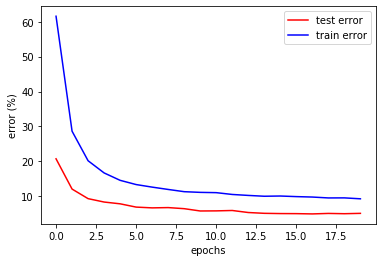

<Figure size 432x288 with 0 Axes>

In [8]:
mlp_ReLU.construct()


#Train
num_epochs = 20
batch_size = 64
edf.learning_rate = 0.1

###############################################################
# TO-DO: call the train_and_test function activating dropout mode.
# Hint : train_err_log, test_err_log = train_and_test(num_epochs, batch_size, mlp_ReLU.x_node, mlp_ReLU.y_node, mlp_ReLU.prob_node, mlp_ReLU.loss_node, ? )
###############################################################


plot(train_err_log, test_err_log)

**3.3.(b).ii.** Train the network without dropout.


Epoch: 1/20 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 11.76 %
	 Test Error 6.65 %
0  :  12 / 980    0.01
1  :  12 / 1135    0.01
2  :  106 / 1032    0.10
3  :  61 / 1010    0.06
4  :  48 / 982    0.05
5  :  100 / 892    0.11
6  :  33 / 958    0.03
7  :  128 / 1028    0.12
8  :  105 / 974    0.11
9  :  60 / 1009    0.06
Epoch: 2/20 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.87 %
	 Test Error 4.68 %
0  :  13 / 980    0.01
1  :  11 / 1135    0.01
2  :  69 / 1032    0.07
3  :  64 / 1010    0.06
4  :  36 / 982    0.04
5  :  27 / 892    0.03
6  :  52 / 958    0.05
7  :  111 / 1028    0.11
8  :  44 / 974    0.05
9  :  41 / 1009    0.04
Epoch: 3/20 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.59 %
	 Test Error 4.03 %
0  :  11 / 980    0.01
1  :  9 / 1135    0.01
2  :  56 / 1032    0.05
3  :  35 / 1010    0.03
4  :  34 / 982    0.03
5  :  23 / 892    0.03
6  :  51 / 958    0.05
7  :  118 / 1028    0.11
8  :  31

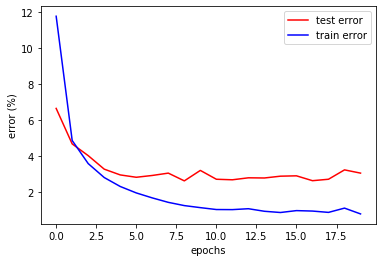

<Figure size 432x288 with 0 Axes>

In [9]:
mlp_ReLU.construct()

#Train
num_epochs = 20
batch_size = 64
edf.learning_rate = 0.1

###############################################################
# TO-DO: call the train_and_test function activating dropout mode.
# Hint : train_err_log, test_err_log = train_and_test(num_epochs, batch_size, mlp_ReLU.x_node, mlp_ReLU.y_node, mlp_ReLU.prob_node, mlp_ReLU.loss_node, ? )
###############################################################

plot(train_err_log, test_err_log)

## Optimization methods

**3.3.(c).** Implement two advanced optimizers: RMSProp and Adam. Our strategy is to store addtional variables such as uncentered variance and velocity in each node. Then we modify gradients by using stored variables after backpropagation. For examples, you can refer to `AdaGradOptimizer` optimization class to understand how it works in the code (you don't have to know about AdaGrad). Note that `p.UpdateParameter()` updates the parameter by adding the multiplication of the ***learning rate*** and the gradient. So, our optimizer computes the update step (without learning rate) then stores it as the gradient.

**3.3.(c).i** Let us implement `RMSPropOptimizer` first. We have to implement two parts: `initialize` and `updateParameters`. `initialize` function initializes the auxiliary variables. `updateParameters` function modifies the gradients according to each optimization method then update the parameters. 



In [10]:
class AdaGradOptimizer:

    epsilon = 0.001

    def __init__(self,  epsilon=0.001):
        self.epsilon = epsilon

    def initialize (self):

        # initialize params
        for p in edf.Parameters:
            p.accum_mag = np.zeros_like ( p.value )

        
    def updateParameters (self):

        for p in edf.Parameters:
            p.accum_mag += p.grad * p.grad
            p.grad = p.grad / np.sqrt ( self.epsilon + p.accum_mag )
            p.UpdateParameters()

class RMSPropOptimizer:

    beta = None
    epsilon = 0.001

    def __init__(self, beta, epsilon=0.001):

        self.beta = beta
        self.epsilon = epsilon

    def initialize (self):

        # initialize params
        for p in edf.Parameters:
            
            #############################################################
            # TO-DO: initialize the uncentered variance v.
            # Hint: set a zero matrix in the same size of the parameter matrix.
            #############################################################


            
    def updateParameters (self):

        for p in edf.Parameters:

            #############################################################
            # TO-DO: compute the uncentered variance then update the gradient
            # Hint: the learning rate will be multiplied in p.UpdateParameters()            
            #############################################################

            
            p.UpdateParameters()


**3.3.(c).i**  Here we set the `MLP` parameters. Then, we construct the MLP network and train the network by using  `RMSPropOptimizer`. You should fill in funtions of `RMSPropOptimizer`.

Epoch: 1/5 (learning rate: 0.001)
	 Batch 400/937
	 Batch 800/937
	 Training Error 9.02 %
	 Test Error 6.05 %
0  :  13 / 980    0.01
1  :  18 / 1135    0.02
2  :  104 / 1032    0.10
3  :  69 / 1010    0.07
4  :  41 / 982    0.04
5  :  36 / 892    0.04
6  :  74 / 958    0.08
7  :  137 / 1028    0.13
8  :  64 / 974    0.07
9  :  49 / 1009    0.05
Epoch: 2/5 (learning rate: 0.001)
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.25 %
	 Test Error 4.32 %
0  :  17 / 980    0.02
1  :  11 / 1135    0.01
2  :  79 / 1032    0.08
3  :  56 / 1010    0.06
4  :  30 / 982    0.03
5  :  21 / 892    0.02
6  :  68 / 958    0.07
7  :  64 / 1028    0.06
8  :  37 / 974    0.04
9  :  49 / 1009    0.05
Epoch: 3/5 (learning rate: 0.001)
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.04 %
	 Test Error 3.63 %
0  :  12 / 980    0.01
1  :  8 / 1135    0.01
2  :  65 / 1032    0.06
3  :  52 / 1010    0.05
4  :  25 / 982    0.03
5  :  15 / 892    0.02
6  :  49 / 958    0.05
7  :  51 / 1028    0.05
8  :  32 / 

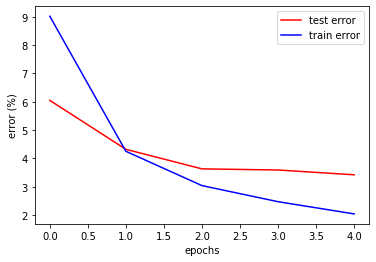

<Figure size 432x288 with 0 Axes>

In [11]:
param = MLPParams()
param.nInputs = 784 # 784-dimension
param.nOutputs = 10 # Output dimension
param.nLayers = 3
param.nHiddens = 64 # Number of neurons in the hidden layer
param.ActivationClass = ReLU
param.RegClass = None
param.alpha = 0.001
param.dropOutProb = 0.5

mlp_ReLU = MLP(param)

mlp_ReLU.construct()

#Train
num_epochs = 5
batch_size = 64
edf.learning_rate = 0.001

#################################################
# To-Do: Generate the RMSPropOptimizer instance 
# Hint: optimizer = RMSPropOptimizer( ?, ? )
# You can set parameter (beta, epsilon) = ( 0.9, 0.00001 )
#################################################

train_err_log, test_err_log = train_and_test(num_epochs, batch_size, mlp_ReLU.x_node, mlp_ReLU.y_node, mlp_ReLU.prob_node, mlp_ReLU.loss_node,optimizer )
plot(train_err_log, test_err_log)

**3.3.(c).ii** Let us implement `AdamOptimizer`. We have to implement two parts: `initialize` and `updateParameters`. `initialize` function initializes the auxiliary variables. `updateParameters` function modifies the gradients according to each optimization method then update the parameters. 

In [12]:

class AdamOptimizer:

    # ratio
    beta_1 = None
    beta_2 = None
    beta_1_t = None
    beta_2_t = None
    epsilon = 0.001

    def __init__(self, beta_1, beta_2, epsilon=0.001):

        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon

    def initialize (self):

        # initialize params
        for p in edf.Parameters:
            #############################################################
            # TO-DO: initialize velocity, uncentered variance, beta_1_t and beta_2_t.
            # Hint:  velocity and uncentered variance should be zero matrix.
            #############################################################
            


            
    def updateParameters (self):



        #############################################################
        # TO-DO: update beta_1_t, beta_2_t
        # Hint: multiply beta with each variable.
        #############################################################

        for p in edf.Parameters:
            #############################################################
            # TO-DO: compute velocity and uncentered variance and update the gradient with corrected update step.
            # Hint: refer to Slide 32 of lecture 6 pdf.
            #############################################################


            p.UpdateParameters()


Epoch: 1/5 (learning rate: 0.001)
	 Batch 400/937
	 Batch 800/937
	 Training Error 10.25 %
	 Test Error 5.68 %
0  :  13 / 980    0.01
1  :  7 / 1135    0.01
2  :  83 / 1032    0.08
3  :  31 / 1010    0.03
4  :  18 / 982    0.02
5  :  92 / 892    0.10
6  :  51 / 958    0.05
7  :  57 / 1028    0.06
8  :  106 / 974    0.11
9  :  110 / 1009    0.11
Epoch: 2/5 (learning rate: 0.001)
	 Batch 400/937
	 Batch 800/937
	 Training Error 4.53 %
	 Test Error 3.98 %
0  :  12 / 980    0.01
1  :  5 / 1135    0.00
2  :  74 / 1032    0.07
3  :  27 / 1010    0.03
4  :  18 / 982    0.02
5  :  41 / 892    0.05
6  :  49 / 958    0.05
7  :  45 / 1028    0.04
8  :  57 / 974    0.06
9  :  70 / 1009    0.07
Epoch: 3/5 (learning rate: 0.001)
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.32 %
	 Test Error 3.55 %
0  :  14 / 980    0.01
1  :  7 / 1135    0.01
2  :  61 / 1032    0.06
3  :  50 / 1010    0.05
4  :  18 / 982    0.02
5  :  29 / 892    0.03
6  :  45 / 958    0.05
7  :  39 / 1028    0.04
8  :  32 / 9

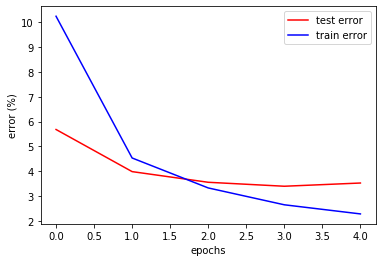

<Figure size 432x288 with 0 Axes>

In [13]:
param = MLPParams()
param.nInputs = 784 # 784-dimension
param.nOutputs = 10 # Output dimension
param.nLayers = 3
param.nHiddens = 64 # Number of neurons in the hidden layer
param.ActivationClass = ReLU
param.RegClass = None
param.alpha = 0.001
param.dropOutProb = 0.5

mlp_ReLU = MLP(param)
mlp_ReLU.construct()

#Train
num_epochs = 5
batch_size = 64
edf.learning_rate = 0.001

#################################################3
# To-Do: Generate the AdamOptimizer instance
# Hint: optimizer = AdamOptimizer( ?,?, 0.001 )
# You can set parameter (beta_1, beta_2, epsilon) = ( 0.9, 0.9, 0.00000001 )
#################################################3

train_err_log, test_err_log = train_and_test(num_epochs, batch_size, mlp_ReLU.x_node, mlp_ReLU.y_node, mlp_ReLU.prob_node, mlp_ReLU.loss_node,optimizer )
plot(train_err_log, test_err_log)

## Data augmentation: vertical and horizontal flip

**3.3.d.i** In this assignment, instead of increasing the variety of valid data pools, we pollute the training data set by flipping images. Let us check how the accuracy changes. To augment the dataset, we now implement the augmentation  class. We transform the input data before the network is trained. Your task is to fill in `RandomFlipAug` class. You can refer to other augmentation class to understand how the augmentation class works.

In [14]:
# Data augmentation

# Gaussian noise
class RandomNoiseAug:

    amplitude_max = 10

    def __init__(self, amplitude_max):
        self.amplitude_max = amplitude_max

    def transform (self, x):

        image_n = x.shape[0]
        x_new = copy.deepcopy(x)

        #
        noise_max = np.random.rand ( image_n, 1, 1 ) * self.amplitude_max
        gaussian_noise = np.random.randn ( x.shape[0], x.shape[1],x.shape[2] )
        gaussian_noise = noise_max * gaussian_noise

        x_new = gaussian_noise + x_new
        x_new [x_new<0] = 0
        x_new [x_new>1] = 1

        return x_new

# Translation
class RandomTranslationAug:

    width = None

    def __init__(self, width):
        self.width = width

    def transform ( self, x ):

        image_n = x.shape[0]
        x_new = copy.deepcopy(x)

        trans_cols = np.array(np.round(np.random.rand ( image_n ) * self.width - 0.4999), dtype = np.int32 )
        trans_rows = np.array(np.round(np.random.rand ( image_n ) * self.width - 0.4999), dtype = np.int32 )

        trans_cols -= int(self.width/2)
        trans_rows -= int(self.width/2)


        # translate for each imgae
        for i in range(0,image_n):

            # wrapping
            x_temp = np.tile(x[i,:,:], [3, 3])

            trans_col = int( trans_cols[i])
            trans_row = int(trans_rows[i])

            x_new[i,:,:]=x_temp[ x.shape[1]+trans_row:x.shape[1]*2+trans_row, x.shape[2] + trans_col : x.shape[2] * 2 + trans_col ]

        return x_new

# Flip
class RandomFlipAug:

    flip_prob_vertical = 0.5
    flip_prob_horizontal = 0.5

    def __init__(self, prob_vertical, prob_horizontal ):
        self.flip_prob_vertical = prob_vertical
        self.flip_prob_horizontal = prob_horizontal

    def transform(self, x):

        image_n = x.shape[0]
        x_new = copy.deepcopy(x)
       
        ##############################################################
        # TO-DO: first generate random samples to decide flipping or not.
        # If the random samples are below than flip_prob_vertical we do vertical flip. 
        # If the random samples are below than flip_prob_horizontal we do horizontal flip.
        # You should generate two random sample per each image.   
        ##############################################################
        


        return x_new

**3.3.d.ii** Check the performance after we flip the training dataset horizontally. How the performance is changed depending on the label?


Epoch: 1/10 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 11.17 %
	 Test Error 67.76 %
0  :  347 / 980    0.35
1  :  189 / 1135    0.17
2  :  998 / 1032    0.97
3  :  341 / 1010    0.34
4  :  670 / 982    0.68
5  :  862 / 892    0.97
6  :  958 / 958    1.00
7  :  966 / 1028    0.94
8  :  694 / 974    0.71
9  :  751 / 1009    0.74
Epoch: 2/10 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.43 %
	 Test Error 65.79 %
0  :  315 / 980    0.32
1  :  133 / 1135    0.12
2  :  996 / 1032    0.97
3  :  301 / 1010    0.30
4  :  534 / 982    0.54
5  :  865 / 892    0.97
6  :  958 / 958    1.00
7  :  1004 / 1028    0.98
8  :  574 / 974    0.59
9  :  899 / 1009    0.89
Epoch: 3/10 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.93 %
	 Test Error 65.50 %
0  :  303 / 980    0.31
1  :  108 / 1135    0.10
2  :  995 / 1032    0.96
3  :  283 / 1010    0.28
4  :  480 / 982    0.49
5  :  869 / 892    0.97
6  :  958 / 958    1.00
7  :  

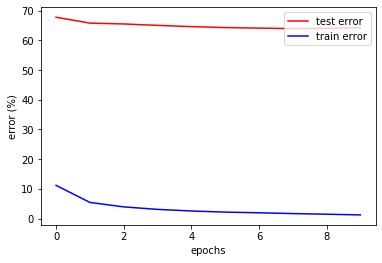

<Figure size 432x288 with 0 Axes>

In [15]:
param = MLPParams()
param.nInputs = 784 # 784-dimension
param.nOutputs = 10 # Output dimension
param.nLayers = 2
param.nHiddens = 64 # Number of neurons in the hidden layer
param.ActivationClass = ReLU
param.RegClass = None
param.alpha = 0.001
param.dropOutProb = 0.5

mlp_ReLU = MLP(param)

mlp_ReLU.construct()

#Train
num_epochs = 10
batch_size = 64
edf.learning_rate = 0.1

# Horizontal flip
#########################################
# TO-DO : generate the RandomFlipAug instance which always flip images horizontally.
# Hint : AugObject =  
#########################################



train_err_log, test_err_log = train_and_test(num_epochs, batch_size, mlp_ReLU.x_node, mlp_ReLU.y_node, mlp_ReLU.prob_node, mlp_ReLU.loss_node, transformer = AugObject, enable_dropout=False)

plot(train_err_log, test_err_log)

**3.3.d.iii** Check the performance after we flip the training dataset vertically. How the performance is changed depending on the label?


Epoch: 1/10 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 11.14 %
	 Test Error 56.23 %
0  :  387 / 980    0.39
1  :  678 / 1135    0.60
2  :  569 / 1032    0.55
3  :  994 / 1010    0.98
4  :  193 / 982    0.20
5  :  883 / 892    0.99
6  :  463 / 958    0.48
7  :  875 / 1028    0.85
8  :  251 / 974    0.26
9  :  330 / 1009    0.33
Epoch: 2/10 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 5.23 %
	 Test Error 55.66 %
0  :  368 / 980    0.38
1  :  571 / 1135    0.50
2  :  609 / 1032    0.59
3  :  1001 / 1010    0.99
4  :  147 / 982    0.15
5  :  886 / 892    0.99
6  :  533 / 958    0.56
7  :  881 / 1028    0.86
8  :  200 / 974    0.21
9  :  370 / 1009    0.37
Epoch: 3/10 (learning rate: 0.1)
	 Batch 400/937
	 Batch 800/937
	 Training Error 3.83 %
	 Test Error 56.31 %
0  :  359 / 980    0.37
1  :  505 / 1135    0.44
2  :  674 / 1032    0.65
3  :  1001 / 1010    0.99
4  :  123 / 982    0.13
5  :  888 / 892    1.00
6  :  568 / 958    0.59
7  : 

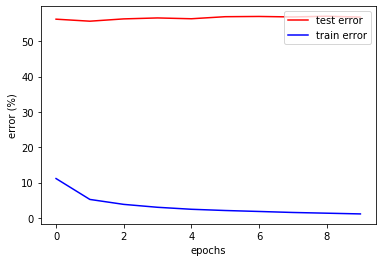

<Figure size 432x288 with 0 Axes>

In [16]:
mlp_ReLU.construct()

#Train
num_epochs = 10
batch_size = 64
edf.learning_rate = 0.1

# Vertical flip
#########################################
# TO-DO : generate the RandomFlipAug instance which always flip images vertically.
# Hint : AugObject =  
#########################################



train_err_log, test_err_log = train_and_test(num_epochs, batch_size, mlp_ReLU.x_node, mlp_ReLU.y_node, mlp_ReLU.prob_node, mlp_ReLU.loss_node, transformer = AugObject, enable_dropout = False)

plot(train_err_log, test_err_log)